# Predicting Cancer Cells Using Logistic Regression

The objective of this work is to build a machine learning model that accurately classifies cancerous cells as either malignant or benign. In this aim, we tested a logistic regression model to evaluate its effectiveness in predicting benign (B) and malignant (M) classifications.

# Connect to the PostgreSQL Database:

In [1]:
# Ignore SQLITE warnings related to Decimal numbers in the database
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import requests
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

db_url = "http://127.0.0.1:5000/api_json_connectivity"
response = requests.get(db_url)
# Check if the request was successful
if response.status_code == 200:
    json_data = response.json()  # Get JSON data
else:
    print(f"Error: {response.status_code}")
    json_data = []
# Step 2: Load the JSON data into a DataFrame
df = pd.DataFrame(json_data)
# Display the first few rows of the DataFrame
df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


# Exploratory data analysis (EDA)

Exploratory Data Analysis (EDA) is a crucial step before applying machine learning, as it helps to understand the underlying structure of the data, identify patterns, and highlight potential issues. Through EDA, we explore the dataset to ensure data quality by checking for missing values, outliers, and imbalanced classes. 

By performing EDA on this cancer dataset, we aim to gain insights that will guide us in preparing the data for building robust machine learning models, improving the model's performance and interpretability.


In [2]:
# To get all column names
df.columns

Index(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave points_mean',
       'concave points_se', 'concave points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'diagnosis',
       'fractal_dimension_mean', 'fractal_dimension_se',
       'fractal_dimension_worst', 'id', 'perimeter_mean', 'perimeter_se',
       'perimeter_worst', 'radius_mean', 'radius_se', 'radius_worst',
       'smoothness_mean', 'smoothness_se', 'smoothness_worst', 'symmetry_mean',
       'symmetry_se', 'symmetry_worst', 'texture_mean', 'texture_se',
       'texture_worst'],
      dtype='object')

In [3]:
# Get the number of columns
df.shape[1]

32

In [4]:
# To check if there are any missing values in each column
df.isnull().sum()

area_mean                  0
area_se                    0
area_worst                 0
compactness_mean           0
compactness_se             0
compactness_worst          0
concave points_mean        0
concave points_se          0
concave points_worst       0
concavity_mean             0
concavity_se               0
concavity_worst            0
diagnosis                  0
fractal_dimension_mean     0
fractal_dimension_se       0
fractal_dimension_worst    0
id                         0
perimeter_mean             0
perimeter_se               0
perimeter_worst            0
radius_mean                0
radius_se                  0
radius_worst               0
smoothness_mean            0
smoothness_se              0
smoothness_worst           0
symmetry_mean              0
symmetry_se                0
symmetry_worst             0
texture_mean               0
texture_se                 0
texture_worst              0
dtype: int64

No missing value in dataset

In [5]:
# Find duplicate rows (returns a boolean series indicating whether each row is a duplicate)
duplicates = df.duplicated()

# Count the number of duplicate rows
df.duplicated().sum()

0

No duplicates found in the dataset

In [6]:
# Check the data types of the columns
df.dtypes

area_mean                  float64
area_se                    float64
area_worst                 float64
compactness_mean           float64
compactness_se             float64
compactness_worst          float64
concave points_mean        float64
concave points_se          float64
concave points_worst       float64
concavity_mean             float64
concavity_se               float64
concavity_worst            float64
diagnosis                   object
fractal_dimension_mean     float64
fractal_dimension_se       float64
fractal_dimension_worst    float64
id                           int64
perimeter_mean             float64
perimeter_se               float64
perimeter_worst            float64
radius_mean                float64
radius_se                  float64
radius_worst               float64
smoothness_mean            float64
smoothness_se              float64
smoothness_worst           float64
symmetry_mean              float64
symmetry_se                float64
symmetry_worst      

In this dataset there is only one categorial variable "diagnosis". The rest of the columns are numerical variables.

In [7]:
# Get the unique values in the 'diagnosis' column
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

This shows distinct values present in the diagnosis column, helping us to understand the categories (such as 'M' for Malignant and 'B' for Benign).

In [8]:
# Display the first few rows of the dataset for further explotation of dataset 
df.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [9]:
# Get summary statistics (mean, min, max, etc.) for numerical columns to check data distribution
df.describe()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,880.583128,0.104341,0.025478,0.254265,0.048919,0.011796,0.114606,0.088799,...,16.269190,0.096360,0.007041,0.132369,0.181162,0.020542,0.290076,19.289649,1.216853,25.677223
std,351.914129,45.491006,569.356993,0.052813,0.017908,0.157336,0.038803,0.006170,0.065732,0.079720,...,4.833242,0.014064,0.003003,0.022832,0.027414,0.008266,0.061867,4.301036,0.551648,6.146258
min,143.500000,6.802000,185.200000,0.019380,0.002252,0.027290,0.000000,0.000000,0.000000,0.000000,...,7.930000,0.052630,0.001713,0.071170,0.106000,0.007882,0.156500,9.710000,0.360200,12.020000
25%,420.300000,17.850000,515.300000,0.064920,0.013080,0.147200,0.020310,0.007638,0.064930,0.029560,...,13.010000,0.086370,0.005169,0.116600,0.161900,0.015160,0.250400,16.170000,0.833900,21.080000
50%,551.100000,24.530000,686.500000,0.092630,0.020450,0.211900,0.033500,0.010930,0.099930,0.061540,...,14.970000,0.095870,0.006380,0.131300,0.179200,0.018730,0.282200,18.840000,1.108000,25.410000
75%,782.700000,45.190000,1084.000000,0.130400,0.032450,0.339100,0.074000,0.014710,0.161400,0.130700,...,18.790000,0.105300,0.008146,0.146000,0.195700,0.023480,0.317900,21.800000,1.474000,29.720000
max,2501.000000,542.200000,4254.000000,0.345400,0.135400,1.058000,0.201200,0.052790,0.291000,0.426800,...,36.040000,0.163400,0.031130,0.222600,0.304000,0.078950,0.663800,39.280000,4.885000,49.540000


<Figure size 2000x1500 with 0 Axes>

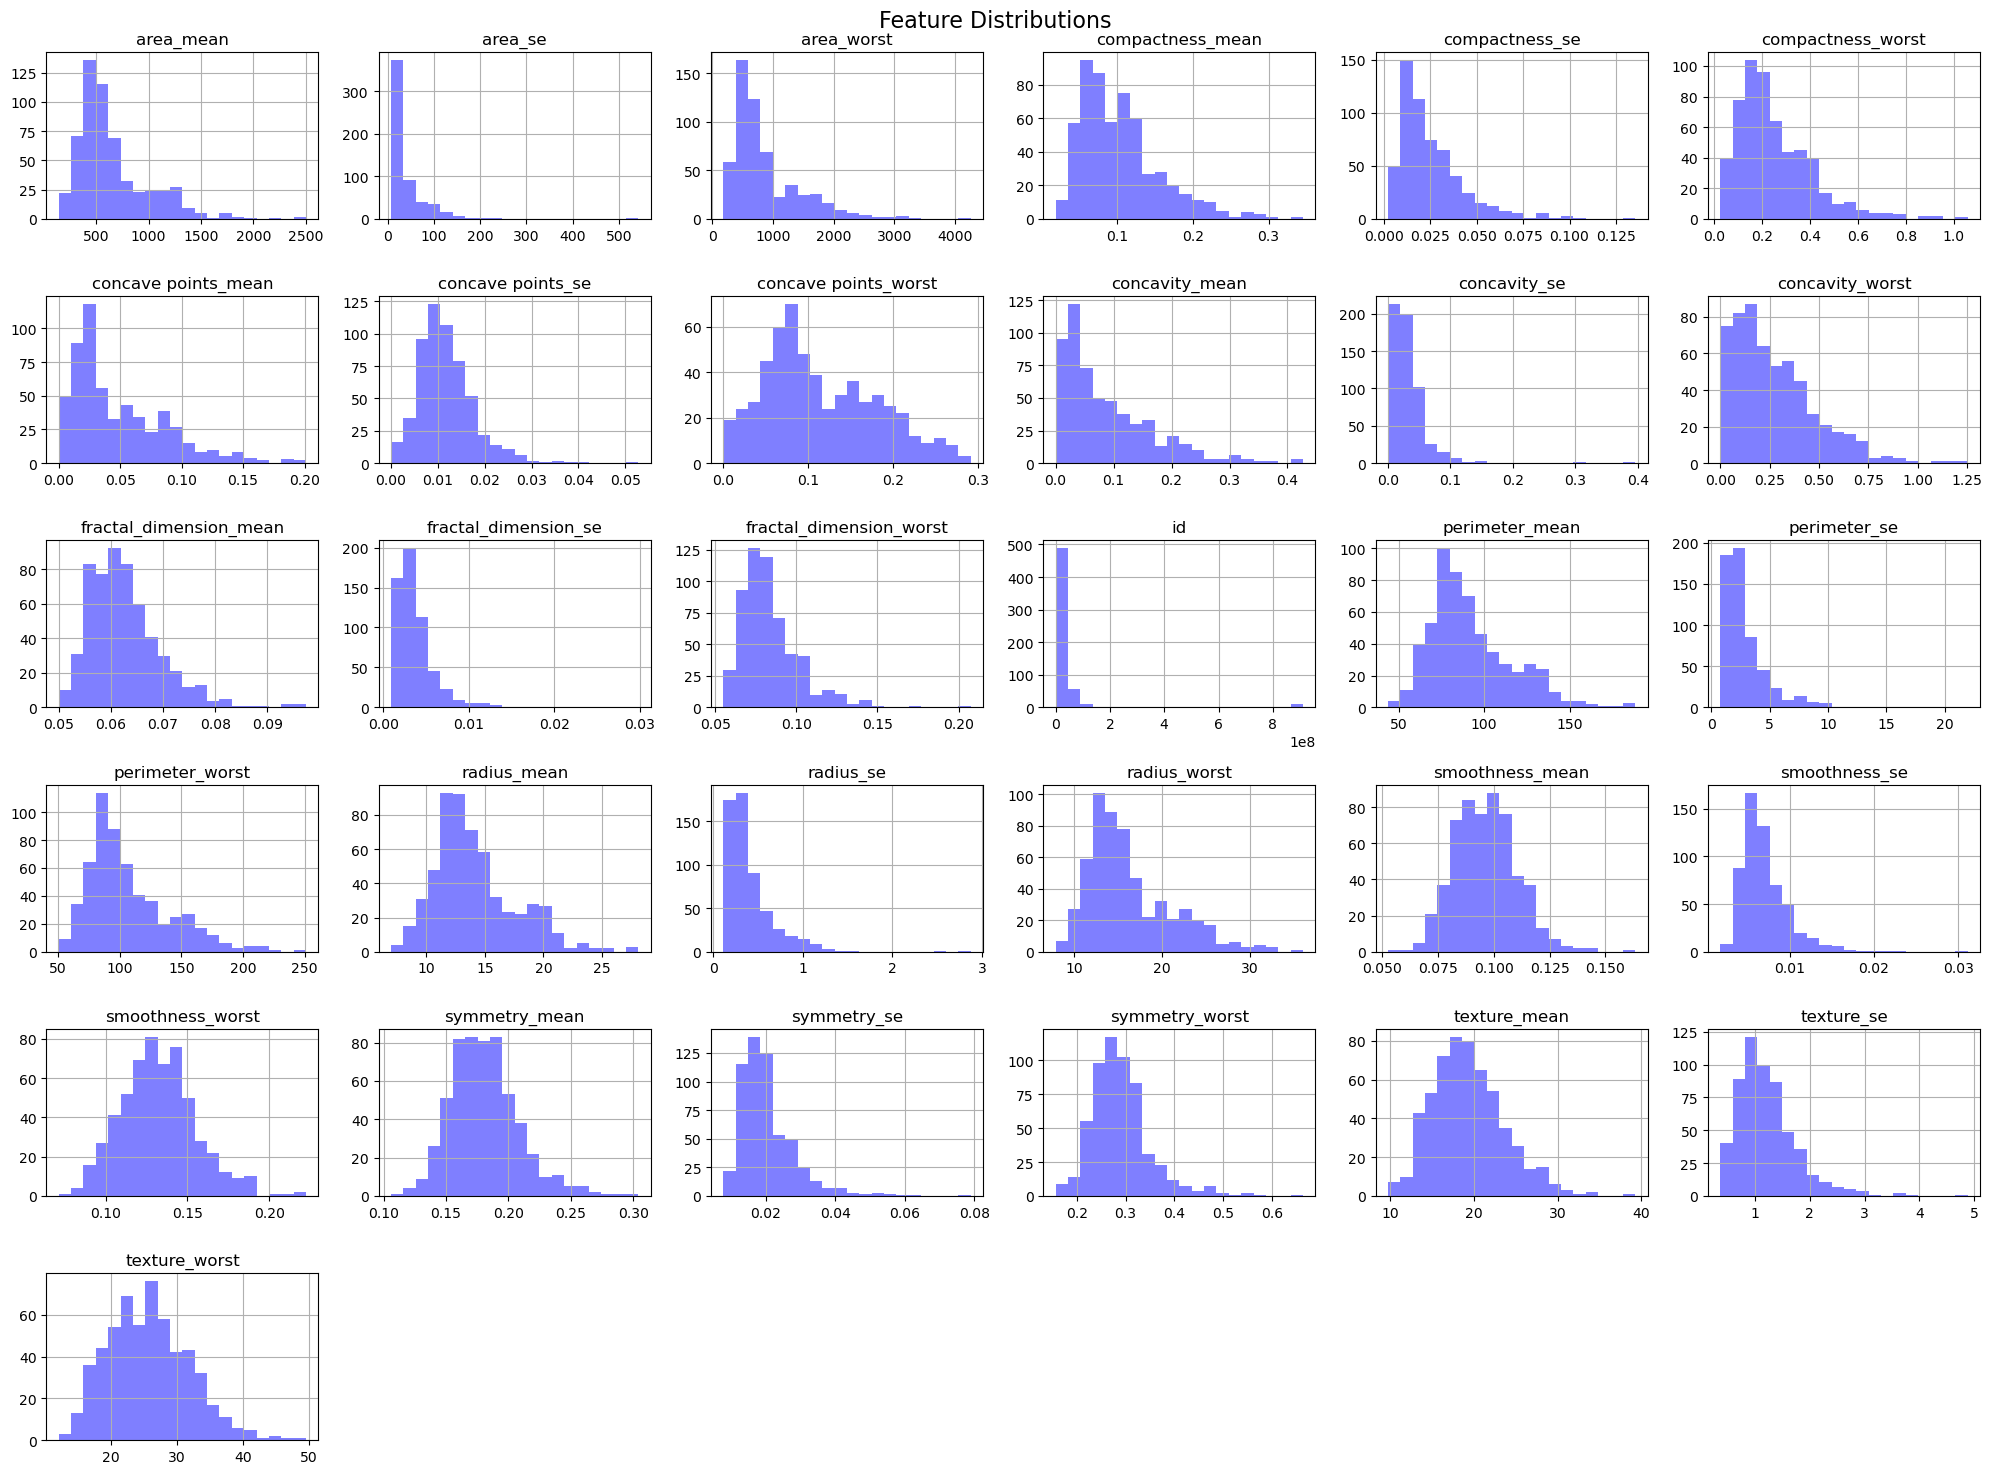

In [10]:
#Check Feature Distributions.

# Plot distributions for malignant cases
plt.figure(figsize=(20, 15))
df.drop(columns=['diagnosis']).hist(bins=20, color='blue', alpha=0.5, figsize=(20, 15))
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

Skewness can often be identified by looking at the histograms of the features.According to above grapgh right skewness can be observed for some features. Since some models are sentive to skewness and outliers this should be handled before splitting the data to train and test.

In [11]:
# Check class imbalance in the 'diagnosis' column
class_distribution = df['diagnosis'].value_counts(normalize=True).round(2) * 100

# Display the class distribution in percentages
print(class_distribution)

diagnosis
B    63.0
M    37.0
Name: proportion, dtype: float64


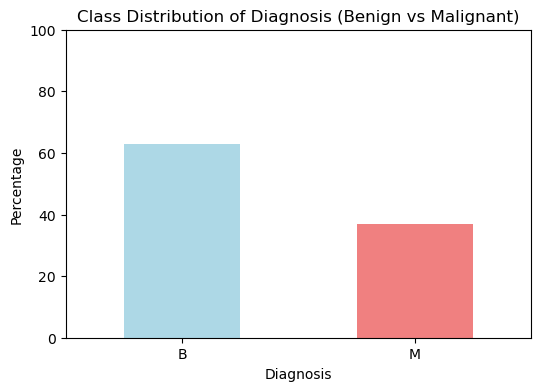

In [12]:
# Plotting the class distribution as a bar chart
plt.figure(figsize=(6,4))
class_distribution.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Class Distribution of Diagnosis (Benign vs Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.show()

The results show an imbalance in the dataset, with more Benign cases than Malignant ones. This imbalance needs to be addressed during the machine learning process to ensure that the model performs well on both classes, especially the minority class (Malignant). Techniques such as using class weights can help mitigate this issue and improve the model's performance for the underrepresented class.

# Data Cleaning and Preprocessing:

In [13]:
# Drop 'Unnamed: 32' and 'id' columns since they are not useful
df_cleaned = df.drop(columns=['id'])

# Check the data types of the columns
df_cleaned.head(5)

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [14]:
# Diagnosis coloumn is objective. Convert this column to numerical values
df_cleaned['diagnosis'] = df_cleaned['diagnosis'].map({'M': 1, 'B': 0})

# Split the data into malignant and benign cases
df_malignant = df_cleaned[df_cleaned['diagnosis'] == 1]
df_benign = df_cleaned[df_cleaned['diagnosis'] == 0]

df_cleaned.head()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,25.38,0.11840,0.006399,0.1622,0.2419,0.03003,0.4601,10.38,0.9053,17.33
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,24.99,0.08474,0.005225,0.1238,0.1812,0.01389,0.2750,17.77,0.7339,23.41
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,23.57,0.10960,0.006150,0.1444,0.2069,0.02250,0.3613,21.25,0.7869,25.53
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,14.91,0.14250,0.009110,0.2098,0.2597,0.05963,0.6638,20.38,1.1560,26.50
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,22.54,0.10030,0.011490,0.1374,0.1809,0.01756,0.2364,14.34,0.7813,16.67


In [15]:
# To get summary statistics (mean, min, max, etc.) for numerical columns
df_cleaned.describe()

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,654.889104,40.337079,880.583128,0.104341,0.025478,0.254265,0.048919,0.011796,0.114606,0.088799,...,16.269190,0.096360,0.007041,0.132369,0.181162,0.020542,0.290076,19.289649,1.216853,25.677223
std,351.914129,45.491006,569.356993,0.052813,0.017908,0.157336,0.038803,0.006170,0.065732,0.079720,...,4.833242,0.014064,0.003003,0.022832,0.027414,0.008266,0.061867,4.301036,0.551648,6.146258
min,143.500000,6.802000,185.200000,0.019380,0.002252,0.027290,0.000000,0.000000,0.000000,0.000000,...,7.930000,0.052630,0.001713,0.071170,0.106000,0.007882,0.156500,9.710000,0.360200,12.020000
25%,420.300000,17.850000,515.300000,0.064920,0.013080,0.147200,0.020310,0.007638,0.064930,0.029560,...,13.010000,0.086370,0.005169,0.116600,0.161900,0.015160,0.250400,16.170000,0.833900,21.080000
50%,551.100000,24.530000,686.500000,0.092630,0.020450,0.211900,0.033500,0.010930,0.099930,0.061540,...,14.970000,0.095870,0.006380,0.131300,0.179200,0.018730,0.282200,18.840000,1.108000,25.410000
75%,782.700000,45.190000,1084.000000,0.130400,0.032450,0.339100,0.074000,0.014710,0.161400,0.130700,...,18.790000,0.105300,0.008146,0.146000,0.195700,0.023480,0.317900,21.800000,1.474000,29.720000
max,2501.000000,542.200000,4254.000000,0.345400,0.135400,1.058000,0.201200,0.052790,0.291000,0.426800,...,36.040000,0.163400,0.031130,0.222600,0.304000,0.078950,0.663800,39.280000,4.885000,49.540000


In [16]:
# Check skewness of all features
df_cleaned.skew()

area_mean                  1.645732
area_se                    5.447186
area_worst                 1.859373
compactness_mean           1.190123
compactness_se             1.902221
compactness_worst          1.473555
concave points_mean        1.171180
concave points_se          1.444678
concave points_worst       0.492616
concavity_mean             1.401180
concavity_se               5.110463
concavity_worst            1.150237
diagnosis                  0.528461
fractal_dimension_mean     1.304489
fractal_dimension_se       3.923969
fractal_dimension_worst    1.662579
perimeter_mean             0.990650
perimeter_se               3.443615
perimeter_worst            1.128164
radius_mean                0.942380
radius_se                  3.088612
radius_worst               1.103115
smoothness_mean            0.456324
smoothness_se              2.314450
smoothness_worst           0.415426
symmetry_mean              0.725609
symmetry_se                2.195133
symmetry_worst             1

High skewness values (greater than 1 or less than -1) indicate that a feature should be transformed. Mild skewness (between -1 and 1) may not require transformation, but we can still experiment if needed. Based on the skewness values we considered transforming the following highly skewed features:
area_se (skewness = 5.45) concavity_se (skewness = 5.11) perimeter_se (skewness = 3.44) radius_se (skewness = 3.09) fractal_dimension_se (skewness = 3.92)

In [17]:
# Features to transform based on high skewness
features_to_transform = ['area_se', 'concavity_se', 'perimeter_se', 'radius_se', 'fractal_dimension_se']

# Apply log1p (log(1 + x)) transformation
for feature in features_to_transform:
    df_cleaned[feature + '_log'] = np.log1p(df_cleaned[feature])


In [18]:
# Define the names of the log-transformed columns
transformed_columns = [feature + '_log' for feature in features_to_transform]

# Check skewness of the log-transformed columns
log_transformed_skewness = df_cleaned[transformed_columns].skew()



In [19]:
df_cleaned.head(5)

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1001.0,153.40,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,74.08,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,94.03,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,27.23,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,94.44,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


In [20]:
# List of the original columns to be removed
columns_to_drop = features_to_transform  # These are the original columns before the log transformation

# Drop the original columns from the DataFrame
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Check the DataFrame to ensure columns have been removed
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se_log,concavity_se_log,perimeter_se_log,radius_se_log,fractal_dimension_se_log
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


In [21]:
# Define the columns to rename
columns_to_rename = {
    'area_se_log': 'area_se',
    'concavity_se_log': 'concavity_se',
    'perimeter_se_log': 'perimeter_se',
    'radius_se_log': 'radius_se',
    'fractal_dimension_se_log': 'fractal_dimension_se'
}

# Renaming the columns in the DataFrame
df_cleaned.rename(columns=columns_to_rename, inplace=True)

# Display the updated column names to verify the changes
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


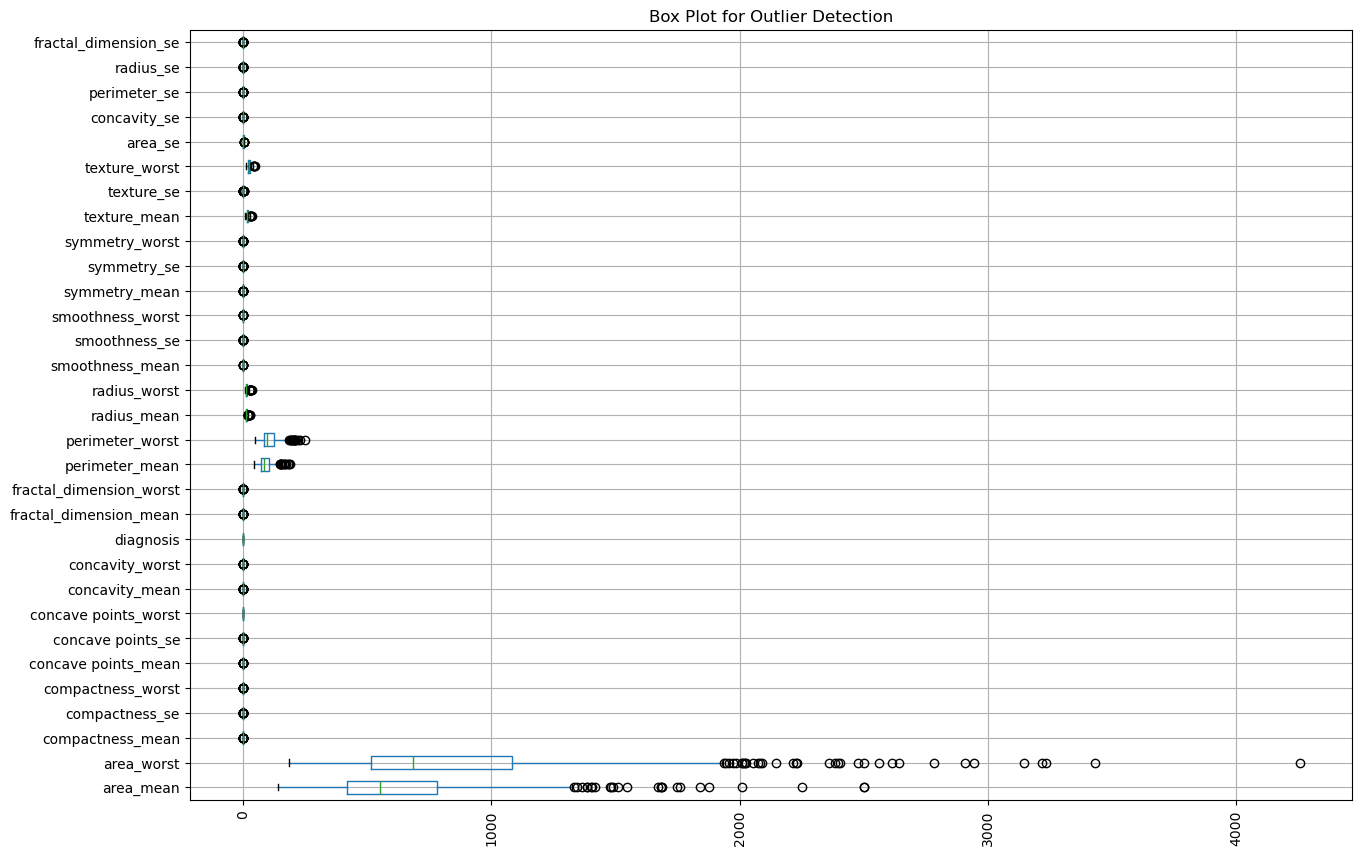

In [22]:
# check outliers and remove or cap. 
# Create boxplots for all the numerical features to detect outliers
df_cleaned.boxplot(figsize=(15, 10), vert=False)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.title("Box Plot for Outlier Detection")
plt.show()

Features that has major Outliers are area_worst perimeter_worst area_mean perimeter_mean
We capped these outliers by replacing values outside the 1st and 99th percentiles with the values at those percentiles.

In [23]:
# Define the features that have major outliers
features_with_outliers = ['area_worst', 'perimeter_worst', 'area_mean', 'perimeter_mean']

# Cap outliers at 1st and 99th percentiles
for feature in features_with_outliers:
    lower_cap = df_cleaned[feature].quantile(0.01)  # 1st percentile
    upper_cap = df_cleaned[feature].quantile(0.99)  # 99th percentile
    
    # Cap the values in the original DataFrame
    df_cleaned[feature] = df_cleaned[feature].clip(lower=lower_cap, upper=upper_cap)

# Check the data after capping outliers
df_cleaned[features_with_outliers].describe()

,area_worst,perimeter_worst,area_mean,perimeter_mean
count,569.000000,569.000000,569.000000,569.000000
mean,876.073835,107.132718,651.295227,91.889771
std,548.004368,33.020473,334.962197,23.752853
min,256.192000,58.270400,215.664000,53.827600
25%,515.300000,84.110000,420.300000,75.170000
50%,686.500000,97.660000,551.100000,86.240000
75%,1084.000000,125.400000,782.700000,104.100000
max,2918.160000,208.304000,1786.600000,165.724000


In [24]:
# Retain the last two rows as unseen data
unseen_data = df_cleaned.tail(2)

# Drop the last two rows from the original DataFrame
df_cleaned = df_cleaned.drop(df_cleaned.tail(2).index)

# Display the unseen data
unseen_data

unseen_data.to_csv('unseen_data.csv', index=False)
print("Unseen data saved as 'unseen_data.csv'")


Unseen data saved as 'unseen_data.csv'


In [25]:
df_cleaned.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


Use this cleaned data to split into Training and Test Sets, scaling and training using different models.

# Logistic Regression: A simple and interpretable model for binary classification.

# 1. Create the labels set (y) from the “diagnosis” column, and then create the features (X) DataFrame from the remaining columns

In [26]:
# Define X (features) and y (target label)
X = df_cleaned.drop('diagnosis', axis=1)  # Features
y = df_cleaned['diagnosis']  # Target

In [27]:
# Review the y variable Series
y[:5]

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [28]:
# Review the X variable DataFrame
X.head()

,area_mean,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,concavity_worst,...,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst,area_se,concavity_se,perimeter_se,radius_se,fractal_dimension_se
0,1001.0,2019.0,0.27760,0.04904,0.6656,0.14710,0.01587,0.2654,0.3001,0.7119,...,0.03003,0.4601,10.38,0.9053,17.33,5.039547,0.052336,2.260617,0.739554,0.006174
1,1326.0,1956.0,0.07864,0.01308,0.1866,0.07017,0.01340,0.1860,0.0869,0.2416,...,0.01389,0.2750,17.77,0.7339,23.41,4.318554,0.018429,1.481150,0.434053,0.003526
2,1203.0,1709.0,0.15990,0.04006,0.4245,0.12790,0.02058,0.2430,0.1974,0.4504,...,0.02250,0.3613,21.25,0.7869,25.53,4.554193,0.037604,1.720084,0.557098,0.004561
3,386.1,567.7,0.28390,0.07458,0.8663,0.10520,0.01867,0.2575,0.2414,0.6869,...,0.05963,0.6638,20.38,1.1560,26.50,3.340385,0.055066,1.491780,0.402527,0.009166
4,1297.0,1575.0,0.13280,0.02461,0.2050,0.10430,0.01885,0.1625,0.1980,0.4000,...,0.01756,0.2364,14.34,0.7813,16.67,4.558498,0.055321,1.862218,0.563722,0.005102


# 2.Split the data into training and testing datasets by using train_test_split

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Check the shape of the training data
print(X_train.shape)


(425, 30)


# 3.Scale the Data

In [30]:
# Initialize the scaler
scaler = StandardScaler()

In [32]:
# Step 3: Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Step 4: Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

# save the scaler
joblib.dump(scaler, './Saved_Models/scaler.pkl')
print("Scaler saved successfully!")


Scaler saved successfully!


# 4. Initialize the Logistic Regression model

In [33]:
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1,
                                class_weight='balanced')

# Fit the model on the scaled training data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=1)

# Save the predictions on the testing data labels by using the testing feature data (X_test_scaled) and the fitted model.¶

In [34]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test_scaled)
Results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
Results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,1,1
9,0,0


In [35]:
# Calculate accuracy score
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy formatted to four decimal places
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


Evaluate the model’s performance by doing the following: Generate a confusion matrix. Print the classification report.

In [36]:
# Create and save the confusion matrix for the testing data
confusion_matrix(y_test, predictions)

array([[88,  2],
       [ 2, 50]])

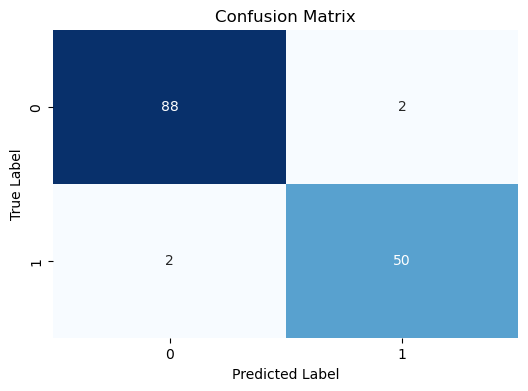

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

confusion matrix shows:
87 True Negatives (correctly predicted Benign cases).
2 False Positives (Benign cases predicted as Malignant).
1 False Negative (Malignant case predicted as Benign).
53 True Positives (correctly predicted Malignant cases).

In [37]:
# Create and save the testing classification report
testing_report = classification_report(y_test, predictions)

# Print the testing classification report
print(testing_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        90
           1       0.96      0.96      0.96        52

    accuracy                           0.97       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.97      0.97       142



The report shows below performance for both classes, with:

Class 0 (Benign): Precision = 0.98, Recall = 0.98, F1-Score = 0.98.

Class 1 (Malignant): Precision = 0.96, Recall = 0.96, F1-Score = 0.96.  

Model is performing well with an average accuracy of around 97%.

In [38]:
#Cross-validation ensures model is evaluated on different subsets of data, improving the robustness of the evaluation.
# we used cross_val_score from scikit-learn to perform cross-validation. 
from sklearn.model_selection import cross_val_score

# Perform cross-validation (5-fold)
cross_val_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5)

# Output the cross-validation scores rounded to two decimal places
cross_val_scores_rounded = [round(score, 2) for score in cross_val_scores]

# Output the cross-validation scores
print("Cross-Validation Scores (rounded):", cross_val_scores_rounded)

# Output the average cross-validation score rounded to two decimal places
average_cv_score = round(cross_val_scores.mean(), 2)
print("Average CV Score (rounded):", average_cv_score)


Cross-Validation Scores (rounded): [1.0, 0.95, 1.0, 0.95, 0.96]
Average CV Score (rounded): 0.97


These are the accuracies obtained by training on 4 parts of the data and validating on the remaining 1 part, repeating this process 5 times.
The mean accuracy across all folds is approximately 0.976, meaning this model is performing well with an average accuracy of around 97.65%.

In [39]:
# Calculate the standard deviation (variance)
variance = cross_val_scores.std()

# Round the variance to two decimal places
variance_rounded = round(variance, 2)

# Print the rounded variance
print(f"Variance (rounded): {variance_rounded}")

Variance (rounded): 0.02


Cross validation showed low variance (0.02), meaning model is quite stable across different data folds. However, we perfromed hyperparameter tuning to  findout a optimal settings for the model to  potentially increase accuracy or reduce variance even more.

# Hyperparameter tune the Logistic Regression model to optimize its performance

In [40]:

# Define the parameter grid
param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [100, 200, 300]
}

# Initialize the model
logistic = LogisticRegression(random_state=1, class_weight='balanced')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the scaled data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")


Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}
Best Cross-Validation Score: 0.98


In [41]:
# Get the best estimator (the model with the best hyperparameters)
tuned_model = grid_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred = tuned_model.predict(X_test_scaled)


# Model Evaluation

Test Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        90
           1       0.98      0.96      0.97        52

    accuracy                           0.98       142
   macro avg       0.98      0.98      0.98       142
weighted avg       0.98      0.98      0.98       142



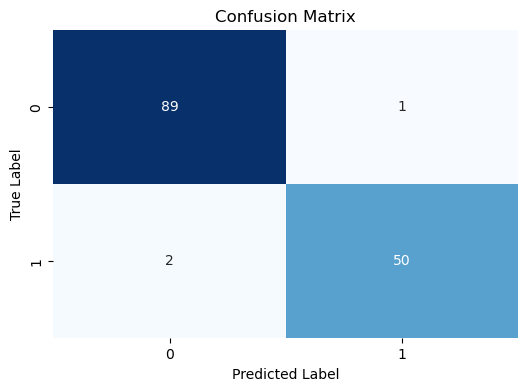

In [42]:
# Evaluate the model's performance on the test data

# Calculate the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [43]:
# Accuracy with initial classifier
classifier_accuracy = accuracy_score(y_test, classifier.predict(X_test_scaled))
print(f"Classifier Accuracy: {classifier_accuracy:.2f}")

# Accuracy with tuned model
tuned_model_accuracy = accuracy_score(y_test, y_pred)  # y_pred is from tuned_model
print(f"Tuned Model Accuracy: {tuned_model_accuracy:.2f}")

Classifier Accuracy: 0.97
Tuned Model Accuracy: 0.98


In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

ROC-AUC Score: 0.9964


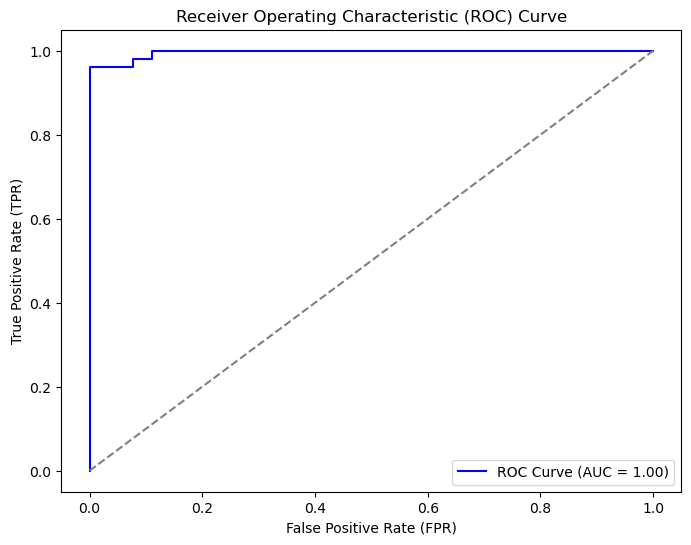

In [45]:
y_prob = tuned_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class (class 1)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(tuned_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Cross-Validation Accuracy: 0.9788 ± 0.0188


In [47]:
from sklearn.metrics import log_loss

# Assuming 'tuned_model' is your best model (e.g., Logistic Regression)
# Use 'predict_proba' to get predicted probabilities for the test data
y_prob = tuned_model.predict_proba(X_test_scaled)

# Calculate Log Loss
logloss = log_loss(y_test, y_prob)

# Print the Log Loss
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.0997


In [48]:
print("Cross-Validation Scores:", cross_val_scores_rounded)
print(f"Average Cross-Validation Score: {average_cv_score}")

Cross-Validation Scores: [1.0, 0.95, 1.0, 0.95, 0.96]
Average Cross-Validation Score: 0.97


In [53]:
# Save the best model to a file. #pip install joblib. 
joblib.dump(tuned_model,'tuned_logistic_regression_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [54]:
# Load the saved model
loaded_model = joblib.load('tuned_logistic_regression_model.pkl')

The tuning has led to a slight improvement in accuracy (from 97% to 98%) and a better balance in precision, recall, and F1-scores across both classes.
The confusion matrix reduced errors from 2 to 1 after tuning for Class 0.



# Feature Selection 

We experimented feature selection using Recursive Feature Elimination (RFE)to check whether using RFE allows us to select the most relevant features for Logistic Regression model. This cal help us to reduce the complexity of the model and potentially improve its generalization and interpretability, which is useful when deploying the model in an app.

RFE can recursively eliminate the least important features until the specified number of features is reached.

In [55]:
from sklearn.feature_selection import RFE

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Step 1: Scale the data
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)



In [56]:
# Step 2: Initialize the Logistic Regression model
model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight='balanced')

In [57]:
# Step 3: Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE on the scaled training data
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)

# Save the fitted RFE object for later use
joblib.dump(rfe, 'rfe_selector.pkl')

# Apply the same transformation to the scaled test data
X_test_rfe = rfe.transform(X_test_scaled)


# Step 4: Train the model on the reduced feature set
model.fit(X_train_rfe, y_train)


LogisticRegression(class_weight='balanced', max_iter=200, random_state=1)

Test Accuracy after RFE: 0.96
Classification Report after RFE:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.96      0.94      0.95        52

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



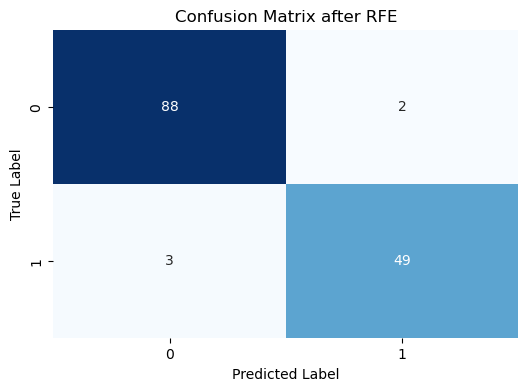

In [58]:

# Step 5: Make predictions using the test data with selected features
y_pred = model.predict(X_test_rfe)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy after RFE: {accuracy:.2f}")

print("Classification Report after RFE:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix after RFE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [59]:
# Tune the model again to check we can improve the model with feature selection. 

# Initialize the logistic regression model with class_weight='balanced'
model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight='balanced')

# Define the parameter grid for tuning
param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'max_iter': [100, 200, 300]
}

# Initialize GridSearchCV with class_weight='balanced'
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the reduced feature set (X_train_rfe)
grid_search.fit(X_train_rfe, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")



Best Parameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.9717647058823531


Test Accuracy after tuning: 0.96
Classification Report after tuning:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.96      0.94      0.95        52

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142



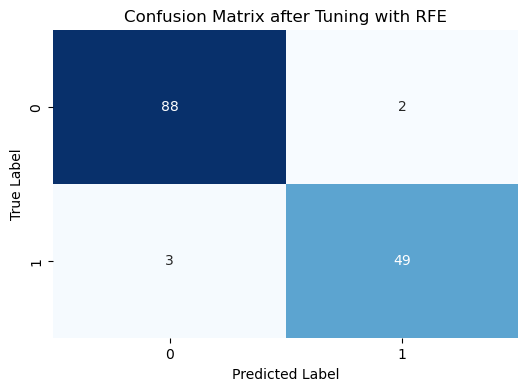

In [60]:
# Step 5: After tuning, get the best model and make predictions
best_model = grid_search.best_estimator_

# Make predictions on the test data using the reduced features (X_test_rfe)
y_pred = best_model.predict(X_test_rfe)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
# Print accuracy rounded to two decimal places
print(f"Test Accuracy after tuning: {accuracy:.2f}")

# Classification Report
print("Classification Report after tuning:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix after Tuning with RFE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



Summary:
The model's performance slightly decreased after feature selection, which is reflected 
a small drop in accuracy (from 98% to 96%).
Minor drops in precision and F1-scores for class 1 (malignant).
Slight increase in misclassifications for class 0 (benign) from 1 to 2.

Feature Selection with RFE slightly reduce the ability of the model to differentiate between the classes. Full feature model performed better than feature selected model for Logistic regression. 
